# FiPy finite-volume modeling of thermal transfer with phase change à la MCM2009

In [1]:
import numpy as np

from numpy import sqrt, pi, exp
from scipy.special import erf, erfc

from fipy import Grid1D, CellVariable
from fipy import TransientTerm, DiffusionTerm

import matplotlib.pyplot as plt

## Some considerations concerning directly changing the heat content in finite-volume cells


|   |   |  |
| -------- | ------------------------ | ---------|
| $T$      | temperature of the material | K        |
| $T_\textrm{ext}$ | exterior temperature  | K        |
| $k$      | thermal conductivity     | W/(m.K)  |
| $\rho$   | mass density             | kg/m3    |
| $c_p$    | specific heat capacity   | J/(kg.K) |
| $\alpha$ | thermal diffusivity      | m2/s     |
| $u$      | specific internal energy | J/kg     |
| $T_\textrm{ref}$ | zero-energy temperature  | K        |
| $U_i$    | internal energy of finite volume #$i$ | J |
| $h_N$    | Newtonian heat transfer coeffcient | W/(m2.K) |
| $A$      | heat transfer area / FV cell wall area  | m2      |
| $w$      | width of finite volume cell | m    |
| $V_\textrm{cell}$ | volume of finite volume cell | m3  |

We have the heat equation

$$ \frac{\partial T}{\partial t} = \frac{k}{\rho c_p} \nabla^2 T $$

We consider here that the material does not undergo any mechanical (pressure, volume) changes, and that the only mode of energy exchange is by means of heat transfer. Changes in internal energy are then the same as changes in enthalpy. Assuming a constant heat capacity, we arrive at the following expression for the (relative) specific energy (or enthalpy, c'est la même chose ici).

$$c_v \approx c_p$$

$$u(T) = c_v(T - T_\textrm{ref})$$


A finite-volume cell has internal energy

$$U_i = V_\textrm{cell} \rho c_p(T_i - T_\textrm{ref})$$

Changes in internal energy of the cell are directly proportional to changes in temperature

$$\Delta U_i = V_\textrm{cell} \rho c_p \Delta T_i$$

or

$$\Delta u_i = \frac{\Delta U_i}{\rho V_\textrm{cell}} =  c_p \Delta T_i$$

This holds for small temperature changes, ignoring any phase change.

With FiPy, we solve the heat equation for temperature, ignoring phase change. 

From the (projected) *change* in temperature of a FV cell, we calculate the *change* in specific internal energy of the cell.

We use this change in internal energy to update the total specific internal energy of the cell.

Then we use equations of state to relate the internal energy of the cell to its 'real' temperature etc.

We update the temperature, etc. of each cell accordingly.

## Equation of state for the water

In this system the thermodynamic state of the water is completely determined by its internal energy/enthalpy relative to a reference point. Energy and enthalpy changes are identical, since we do not consider mechanical changes (pressure, volume).

We refer to this internal energy as $u$.

If we know internal energy $u$, we can determine all other properties as a function of $u$: temperature, thermal diffusivity, heat capacity.

In [2]:
T_0 = -10. # initial ice temperature °C
T_w = 20. # external boundary temperature °C
T_f = 0. # melting temperature °C

rho_s = 917.0 # ice density kg/m3
rho_l = 1000.0 # water density kg/m3

c_s = 2108. # ice heat capacity J/(K.kg)
c_l = 4184. # water heat capacity J/(K.kg)

k_s = 2.2199 # ice thermal conductivity W/(m.K)
k_l = 0.5918 # water thermal conductivity W/(m.K)

# rigorously apply mu = k / rho ci
mu_s = k_s/(rho_s*c_s)  # ice thermal diffusivity
mu_l = k_l/(rho_l*c_l) # water thermal diffusivity (m^2/s)

h_fus = +334000. # latent heat (J / kg)

The thermodynamic data should be updated and rigorously applied

This is needed if we want to build a reliable calculation using

$T(u) = f(u)$

converting $\Delta T$ between time steps in $\Delta u$ for calculation of $u$ and then calculating the new temperatures from $T = T(u)$


In [3]:
# now for a realistic T vs u function
# and apply this to temperature on each time step
# attention! vectors only
uT0s = 10. * c_s
uT0l = 10. * c_s + h_fus
def T_from_u(u):
    Tu = np.zeros_like(u)
    Tu[:] = 0.0
    Tu[u<uT0s] = (-10. + u[u<uT0s]/c_s)
    Tu[u>uT0l] = (u[u>uT0l]-uT0l)/c_l
    return Tu

# also adapt mu
def mu_from_u(u):
    muu = np.zeros_like(u)
    muu[:] = mu_s # solid diffusivity
    muu[u>uT0l] = mu_l # liquid diffusivity when completely molten
    # perhaps use halfway the melting as the switch moment...
    # or transition?
    return muu

def c_from_u(u):
    cu = np.zeros_like(u)
    cu[:] = c_s # solid heat capacity
    cu[u>uT0l] = c_l # liquid heat capacity when completely molten
    # transition?
    return cu

Text(0.5, 0, 'specific internal energy $u$ (kJ / kg)')

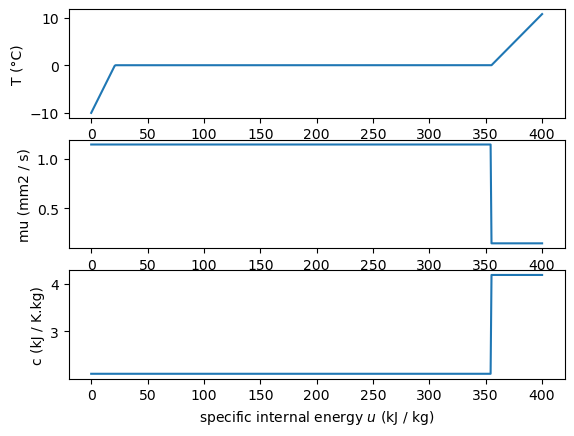

In [4]:
uu = np.linspace(0,400000,500)
plt.subplot(311)
plt.plot(uu/1000,T_from_u(uu))
plt.ylabel('T (°C)')
plt.subplot(312)
plt.plot(uu/1000,mu_from_u(uu)/1e-6)
plt.ylabel('mu (mm2 / s)')
plt.subplot(313)
plt.plot(uu/1000,c_from_u(uu)/1000)
plt.ylabel('c (kJ / K.kg)')
plt.xlabel('specific internal energy $u$ (kJ / kg)')

## FiPy finite-volume model

$$\alpha = \frac{k}{\rho c_p}$$

rename this according to MCM2009:

$$\mu_i = \frac{k_i}{\rho_i c_i}$$

where subscript $i$ is $s$ for solid and $l$ for liquid

let's assume $\rho$ is always 1000 kg per kuub

we can make $\mu$ a CellVariable

In [5]:
# we use a system similar to MCM 2009, see plots of analytic work below

Text = 20.
Tinit = -10.

L = 1.0 # 1 meter should be enough
Nx = 500 # can be more if needed, enough computational power, keep uniform grid for now
dx = L/Nx

In [6]:
msh = Grid1D(nx=Nx, dx=dx)

In [7]:
x = msh.cellCenters.value[0] # x is depth

In [8]:
mu = CellVariable(mesh = msh, name = 'µ')

In [9]:
mu[:] = mu_s

In [10]:
T = CellVariable(mesh = msh, name = 'T')

In [11]:
T[:] = Tinit

In [12]:
T.constrain(Text, msh.facesLeft)

In [13]:
T.constrain(Tinit, msh.facesRight)

In [14]:
Tview = T.value

In [15]:
c = np.zeros_like(Tview)

In [16]:
c[:] = c_s # cell's heat capacity is ice heat capacity

In [17]:
u = np.zeros_like(Tview)

In [18]:
u[:] = 0.0 # cell's specific enthalpy

In [19]:
eq = TransientTerm(var = T) == DiffusionTerm(coeff = mu, var = T)

In [20]:
# reinitialize
T[:] = Tinit
c[:] = c_s # cell's heat capacity is ice heat capacity
u = np.zeros_like(Tview)
u[:] = 0.0 # cell's specific enthalpy

In [21]:
ix5cm = np.argmin(np.abs(x-0.05)) # position nearest 5 cm
print(ix5cm, x[ix5cm]) # this is 4.9 cm, next point is 5.1 cm so take average of ix5cm and ix5cm+1 cells

24 0.049


Text(0, 0.5, 'T (°C)')

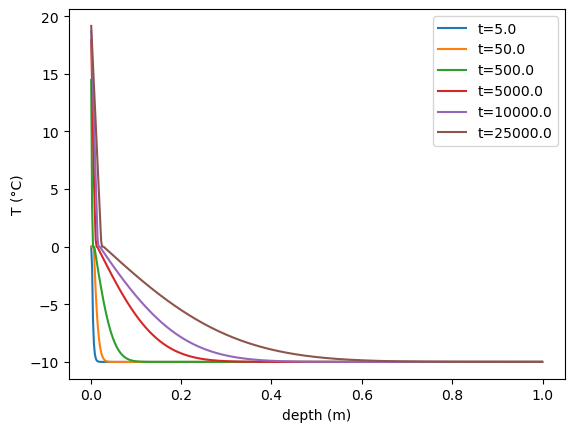

In [22]:
deltat = 5.0 # 1 second?
showix = [1, 10, 100, 1000, 2000, 5000]
Nt = 5001
t = 0
t_numwerts = np.zeros(Nt)
T5cm_numwerts = np.zeros(Nt)
for ix in range(Nt):
    # sample 5cm (take average at ix5cm and ix5cm+1)
    t_numwerts[ix] = t
    T5cm_numwerts[ix] = (Tview[ix5cm] + Tview[ix5cm+1])/2
    
    if ix in showix:
        plt.plot(x, Tview, label='t={0:.1f}'.format(t))
        # plt.plot(x, T_from_u(u), 'k:')
        if ix == 2000: # this is the 10000 second point
            T10000_numwerts = Tview.copy()
            x10000_numwerts = x.copy()
    Tpre = T.value.copy()
    eq.solve(dt = deltat); t+= deltat
    Tpost = T.value.copy()
    deltaT = Tpost-Tpre
    deltau = c * deltaT
    u += deltau
    T[:] = T_from_u(u)
    mu[:] = mu_from_u(u)
    c[:] = c_from_u(u)
plt.legend()
plt.xlabel('depth (m)')
plt.ylabel('T (°C)')

In [23]:
# assert 1==0, "break"

## Comparison between numerical FiPy solution (werts) and analytic MCM2009 curves

We copy the code from the Notebook `MCM2009_analytical_solution.ipynb`

In [24]:
# set/adapt variable names
T_0 = -10. # initial ice temperature °C
T_w = 20. # external boundary temperature °C
T_f = 0. # melting temperature °C

C_s = c_s # just rename existing variables for compatibility with next part of Notebook
C_l = c_l

µ_s = mu_s
µ_l = mu_l

L = -334000. # latent heat (J / kg)

In [25]:
def solid_liquid(xx_sl):
    """
    Left-hand side (LHS) of Eqn. 6.
    
    We should find xx_sl such that this function is zero.
    
    *Warning* Do not evaluate this function close to $x^{*}_{sl} = 0$, since it will diverge there.
    """
    global T_f, T_0, T_w
    global k_l, k_s
    global µ_s, µ_l
    global C_s, C_l
    global L
    
    A1 = (T_f - T_0) / (T_f - T_w)
    A2 = k_s/k_l
    A3 = sqrt(µ_l/µ_s)
    A4 = exp(-(µ_l/µ_s)*xx_sl**2) / erfc(sqrt(µ_l/µ_s)*xx_sl)
    A = A1*A2*A3*A4
    
    B = exp(-xx_sl**2) / erf(xx_sl)
    
    C = (sqrt(pi)*xx_sl*L) / (C_l * (T_f - T_w))
    
    return A+B-C

In [26]:
def T_profile_MCM2009(x, t, xxsl):
    global T_w, T_f
    global T_0
    global µ_l
    global µ_s
    xx = x/(2*sqrt(µ_l*t))
    T = np.zeros_like(xx)
    T[xx<xxsl0] = T_w + (T_f-T_w) * (erf(xx[xx<xxsl])/erf(xxsl))
    T[xx>=xxsl0] = T_0 + (T_f-T_0) * (erfc(sqrt(µ_l/µ_s)*xx[xx>=xxsl])/erfc(sqrt(µ_l/µ_s)*xxsl))
    return T

In [27]:
from secant import secant

In [28]:
xxsl0 = secant(solid_liquid, 1e-4, 1.0)

Finally, we do a quick comparison between the first FiPy results and the analytic curves from MCM2009.

We only sampled:
1. The temperature depth profile at t=10000s
2. The temperature evolution at 5 cm depth from 0 to 20000s

More comparisons should be done. How well do the curves compare? What are the differences? What could be done to improve the agreement? Does it help to find better expressions for the heat capacity and the thermal diffusivity in the 'mushy' zone?

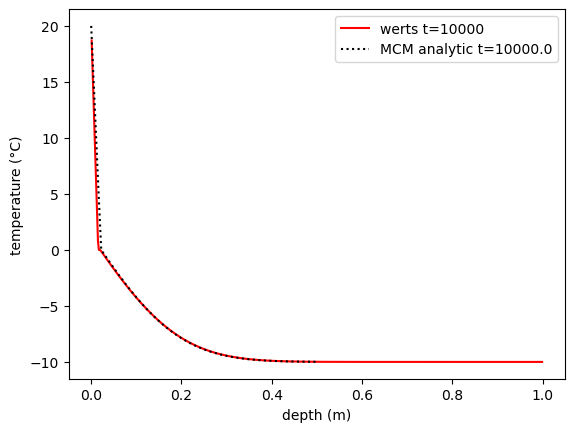

In [29]:
plt.plot(x10000_numwerts,T10000_numwerts,'r',label='werts t=10000')

x = np.linspace(0,0.5,1000)
T = np.zeros_like(x)
t = 10000.
T = T_profile_MCM2009(x, t, xxsl0)
plt.plot(x,T, 'k:', label='MCM analytic t={0:.1f}'.format(t))
plt.xlabel('depth (m)')
plt.ylabel('temperature (°C)')
plt.legend()

In [30]:
x = 0.05
t = np.linspace(0.001,50*3600.,500)
T = T_profile_MCM2009(x, t, xxsl0)

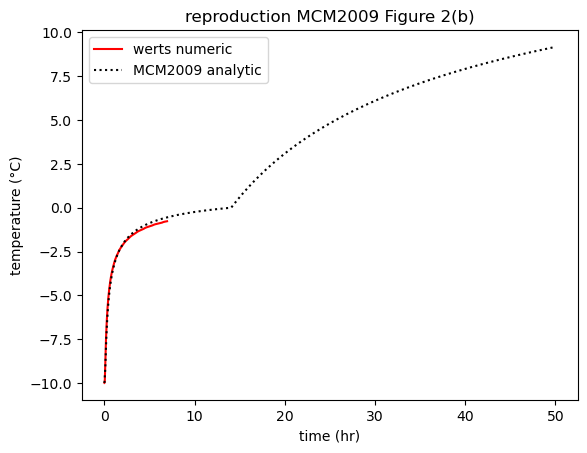

In [31]:
plt.plot(t_numwerts/3600,T5cm_numwerts,'r',label='werts numeric')
plt.plot(t/3600,T,'k:',label='MCM2009 analytic')
plt.xlabel('time (hr)')
plt.ylabel('temperature (°C)')
plt.title('reproduction MCM2009 Figure 2(b)')
plt.legend()